# Ecuación de Difusión en 2D implementado en Mallas Lógicamente Rectangulares.

Función que calcula una aproximación a la solución de la ecuación de Difusión en 2D utilizando Diferencias Finitas Generalizadas en Mallas lógicamente rectangulares.

El problema que se resuelve es:

\begin{align}
\frac{\partial u}{\partial t}= \nu\nabla^2 u
\end{align}

El número de vecinos varia dependiendo del nodo.

### Parámetros de entrada
    x           m x n       double      Matriz con las coordenadas en $x$ de los nodos.
    y           m x n       double      Matriz con las coordenadas de $y$ de los nodos.
    fDIF                    function    Función declarada con la condición inicial y de frontera.
    v                       real        Coeficiente de difusión.
    t                       integer     Número de pasos en el tiempo.

### Parámetros de salida
    u_ap        m x 1       double      Vector con la aproximación calculada por el método.
    u_ex        m x 1       double      Vector con la solución exacta del problema.

In [ ]:
# Se elige la nube en la que se va a trabajar
malla = 'CAB21'

# Se elige el tamaño de la discretización temporal
t   = 1000

# Se elige el coeficiente de difusion
nu = 0.4

## Inicialización del Problema
Se inicializa lo necesario para el problema:


1.   Se importan las librerías necesarias.
2.   Se cargan los datos de la región.
3.   Se definen las condiciones iniciales y de frontera.

### Importación de Librerias
En esta parte se importan las librerias necesarias para ejecutar todo el código. En particual se importan:

*   **numpy**. Para poder hacer la mayor parte de los cálculos numéricos.
*   **math**. Permite hacer uso de diferentes funciones matemáticas.
*   **matplotlib**. Para hacer las gráficas necesarias.
*   **scipy**. Para usar una gran cantidad de funciones matemáticas.

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sys import path
path.insert(0, '../Generales/')
from Gammas import Gammas_Mesh as Gammas
from Errores import ECM_mesh_transient as ECM
from Graficar import Mesh_Transient as Graph
from Graficar import Error as graphEr
from scipy.io import loadmat

### Se cargan los datos de la region

En esta parte se cargan los datos de la region desde un archivo .mat y se guardan en sus respectivas variables $x$ y $y$.

In [ ]:
# Se cargan todos los datos desde el archivo
mat = loadmat('../Regiones/Mallas/' + malla + '.mat')

# Se guardan los datos de los nodos
x = mat['x']
y = mat['y']

# Se imprimen los nodos para asegurarnos de que se cargan correctamente.
plt.scatter(x,  y,  s = 1)
plt.title('Malla de la región')
plt.show()

### Se definen las condiciones iniciales y de frontera

Las condiciones iniciales y de frontera serán definidas como:
<center>
  $f = e^{-2*\pi^2vt}\cos(\pi x)cos(\pi y)$
</center>

In [ ]:
def fDIF(x, y, t, v):
    fun = math.exp(-2*math.pi**2*v*t)*math.cos(math.pi*x)*math.cos(math.pi*y)
    return fun

## Diferencias Finitas Generalizadas
Se resuelve el problema de Diferencias Finitas Generalizadas.

In [57]:
def Diffusion_Mesh(x, y, f, nu, t):
    me   = x.shape                                                                  # Se encuentra el tamaño de la malla.
    m    = me[0]                                                                    # Se encuentra el número de nodos en x.
    n    = me[1]                                                                    # Se encuentra el número de nodos en y.
    T    = np.linspace(0,1,t)                                                       # Se hace la malla en el tiempo.
    dt   = T[1] - T[0]                                                              # Se calcula dt.
    u_ap = np.zeros([m, n, t])                                                      # Se inicializa u_ap con ceros.
    u_ex = np.zeros([m, n, t])                                                      # Se inicializa u_ex con ceros.

    ## Condiciones de Frontera
    for k in np.arange(t):
        for i in np.arange(m):                                                      # Para cada uno de los nodos en las fronteras en x.
            u_ap[i, 0,   k] = f(x[i, 0], y[i, 0], T[k], nu)                         # Se agrega la condición de frontera.
            u_ap[i, n-1, k] = f(x[i, n-1], y[i, n-1], T[k], nu)                     # Se agrega la condición de frontera.
        for j in np.arange(n):                                                      # Para cada uno de los nodos en las fronteras en y.
            u_ap[0,   j, k] = f(x[0, j], y[0, j], T[k], nu)                         # Se agrega la condición de frontera.
            u_ap[m-1, j, k] = f(x[m-1, j], y[m-1, j], T[k], nu)                     # Se agrega la condición de frontera.
  
    ## Condición Inicial
    for i in np.arange(m):
        for j in np.arange(n):
            u_ap[i, j, 0] = f(x[i, j], y[i, j], T[0], nu)                           # Se agrega la condición inicial

    # Ahora, se calculan las Gammas
    L = np.vstack([[0], [0], [2*nu*dt], [0], [2*nu*dt]])                            # Se asignan los valores para el operador diferencial.
    Gamma = Gammas(x, y, L)                                                         # Se calculan las Gammas.


    for k in np.arange(1,t):
        for i in np.arange(1,m-1):
            for j in np.arange(1,n-1):
                u_ap[i, j, k] = u_ap[i, j, k-1] + (\
                    Gamma[i, j, 0]*u_ap[i    , j    , k-1] + \
                    Gamma[i, j, 1]*u_ap[i + 1, j    , k-1] + \
                    Gamma[i, j, 2]*u_ap[i + 1, j + 1, k-1] + \
                    Gamma[i, j, 3]*u_ap[i    , j + 1, k-1] + \
                    Gamma[i, j, 4]*u_ap[i - 1, j + 1, k-1] + \
                    Gamma[i, j, 5]*u_ap[i - 1, j    , k-1] + \
                    Gamma[i, j, 6]*u_ap[i - 1, j - 1, k-1] + \
                    Gamma[i, j, 7]*u_ap[i    , j - 1, k-1] + \
                    Gamma[i, j, 8]*u_ap[i + 1, j - 1, k-1])

    for k in np.arange(t):
        for i in np.arange(m):
            for j in np.arange(n):
                u_ex[i, j, k] = f(x[i, j], y[i, j], T[k], nu)                                    # Se coloca la solución exacta.

    return u_ap, u_ex

## Ejecución

En esta parte se ejecuta el código para obtener los resultados. También se grafica la solución.

In [58]:
u_ap, u_ex = Diffusion_Mesh(x, y, fDIF, nu, t)

El error máximo cometido para el método es de:  0.0001827292098863311


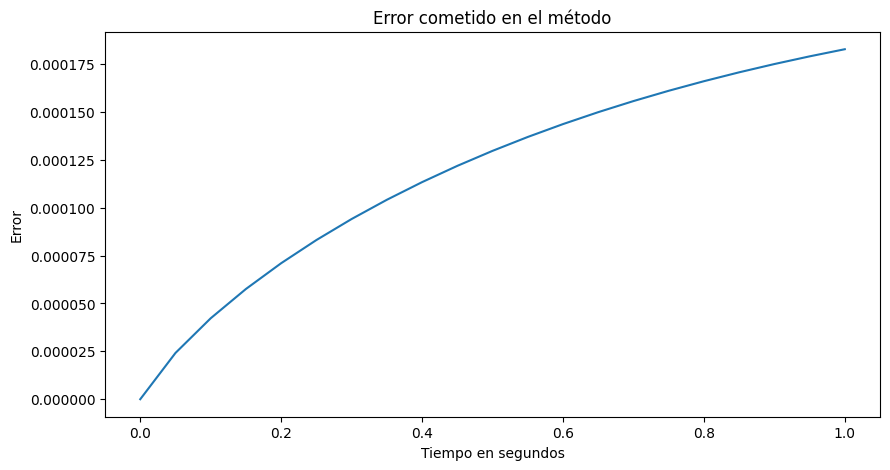

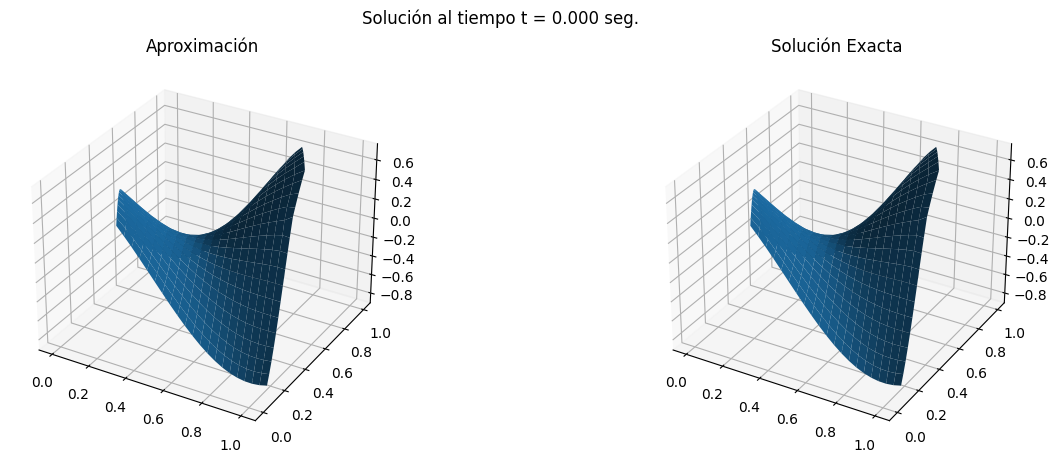

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [72]:
er = ECM(x, y, u_ap, u_ex)
print('El error máximo cometido para el método es de: ', er.max())
graphEr(er)
Graph(x, y, u_ap, u_ex)